# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov


## A. Simulation

In [2]:
import pickle
from simulation import MultiTODSimulation
# Load the simulation data from a pickle file
with open('multi_tod_simulation_data.pkl', 'rb') as f:
    multi_tod_sim = pickle.load(f)

In [3]:

# Make all the individual variables available for backward compatibility
t_list = multi_tod_sim.t_list
theta_c_setting = multi_tod_sim.theta_c_setting
phi_c_setting = multi_tod_sim.phi_c_setting
theta_c_rising = multi_tod_sim.theta_c_rising
phi_c_rising = multi_tod_sim.phi_c_rising
bool_map_setting = multi_tod_sim.bool_map_setting
bool_map_rising = multi_tod_sim.bool_map_rising
integrated_beam_setting = multi_tod_sim.integrated_beam_setting
integrated_beam_rising = multi_tod_sim.integrated_beam_rising
full_bool_map = multi_tod_sim.full_bool_map
pixel_indices = multi_tod_sim.pixel_indices
integrated_beam = multi_tod_sim.integrated_beam
Tsky_operator_setting = multi_tod_sim.Tsky_operator_setting
Tsky_operator_rising = multi_tod_sim.Tsky_operator_rising
sky_params = multi_tod_sim.sky_params
ntime = multi_tod_sim.ntime
ndiode_proj = multi_tod_sim.ndiode_proj
nd_rec_operator = multi_tod_sim.nd_rec_operator
nd_rec_params = multi_tod_sim.nd_rec_params
gain_proj = multi_tod_sim.gain_proj
gain_params_setting = multi_tod_sim.gain_params_setting
gain_params_rising = multi_tod_sim.gain_params_rising
gains_setting = multi_tod_sim.gains_setting
gains_rising = multi_tod_sim.gains_rising
fc = multi_tod_sim.fc
logfc = multi_tod_sim.logfc
f0 = multi_tod_sim.f0
noise_setting = multi_tod_sim.noise_setting
noise_rising = multi_tod_sim.noise_rising
Tsys_setting = multi_tod_sim.Tsys_setting
Tsys_rising = multi_tod_sim.Tsys_rising
TOD_setting = multi_tod_sim.TOD_setting
TOD_rising = multi_tod_sim.TOD_rising
pixels_c_setting = multi_tod_sim.pixels_c_setting
bool_map_c_setting = multi_tod_sim.bool_map_c_setting
calibration_1_index = multi_tod_sim.calibration_1_index
calibration_5_indices = multi_tod_sim.calibration_5_indices

# Additional constants from the original code
T_ndiode = multi_tod_sim.T_ndiode
rec_params = multi_tod_sim.rec_params
dtime = multi_tod_sim.dtime
alpha = multi_tod_sim.alpha
logf0_list = [multi_tod_sim.logf0]
sigma_2 = multi_tod_sim.sigma_2

In [4]:
def reduce_bool_maps_LAND(bool_maps):
    """
    Reduce a list of boolean maps using the "logical and" operation.
    """
    reduced_map = np.logical_and.reduce(bool_maps)
    # Get the pixel indices of the "1" pixels:
    pixel_indices = np.where(reduced_map)[0]
    return reduced_map, pixel_indices

In [5]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.zeros(4)
gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%
gain_prior_mean = gain_params_setting

prior_std_frac = 0.1
Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
calibration_indices = calibration_1_index
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = np.ones_like(nd_rec_params)*0.0
aux[0] = 1
#Trec_prior_cov_inv = [aux] # Effectlively no prior

Trec_prior_cov_inv_list = [aux, aux]

def log_prior_noise(params):
    _, alpha_est = params
    return -1e10 * (alpha_est - alpha)**4 

In [13]:
# class TOD_sim:
#     def __init__(self, t_list, theta_c, phi_c, 
#                  TOD, gain_proj, Tsky_proj, nd_rec_proj,
#                  ):
#         self.t_list = None
#         self.theta_c = None
#         self.phi_c = None

In [6]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

# Debug: Check the shapes of input data
print("Debugging shapes:")
print(f"TOD_setting shape: {TOD_setting.shape}")
print(f"TOD_rising shape: {TOD_rising.shape}")
print(f"t_list shape: {t_list.shape}")
print(f"gain_proj shape: {gain_proj.shape}")
print(f"Tsky_operator_setting shape: {Tsky_operator_setting.shape}")
print(f"Tsky_operator_rising shape: {Tsky_operator_rising.shape}")
print(f"nd_rec_operator shape: {nd_rec_operator.shape}")
print(f"init_Tsys_params shape: {init_Tsys_params.shape}")
print(f"logfc: {logfc}")

# Check if the time arrays are consistent
print(f"\nTime array info:")
print(f"ntime: {ntime}")
print(f"t_list min: {t_list.min()}, max: {t_list.max()}")

# Test the lag calculation
from utils import lag_list
tau_test = lag_list(t_list)
print(f"tau_list shape: {tau_test.shape}")
print(f"tau_list first few values: {tau_test[:5]}")

try:
    Tsys_samples, all_gain_samples, all_noise_samples = \
        full_Gibbs_sampler_multi_TODS_v2([TOD_setting, TOD_rising],
                                        [t_list, t_list],
                                        [gain_proj, gain_proj],
                                        [Tsky_operator_setting, Tsky_operator_rising],
                                        [nd_rec_operator, nd_rec_operator],
                                        init_Tsys_params,
                                        init_noise_params, 
                                        [logfc, logfc],
                                        num_Jeffrey=False,
                                        wnoise_var=2.5e-6,
                                        Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                        Tsky_prior_mean=sky_params,
                                        local_Trec_prior_cov_inv_list=Trec_prior_cov_inv_list,
                                        local_Trec_prior_mean_list=[nd_rec_params, nd_rec_params],
                                        local_gain_prior_cov_inv_list=[gain_prior_cov_inv,gain_prior_cov_inv],
                                        local_gain_prior_mean_list=[gain_params_setting,gain_params_rising],
                                        # local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                        n_samples=10,  # Reduced for debugging
                                        tol=1e-12)
except Exception as e:
    print(f"Error occurred: {e}")
    import traceback
    traceback.print_exc()
    
    # Let's try to isolate the issue
    print("\nTesting individual components...")
    
    # Test the flicker noise sampler directly
    try:
        from noise_sampler_fixed_fc import flicker_noise_sampler
        
        # Test with first TOD
        test_gains = gain_proj @ gain_params_setting
        test_Tsys = Tsky_operator_setting @ sky_params + nd_rec_operator @ nd_rec_params
        
        print("Testing flicker noise sampler...")
        noise_test = flicker_noise_sampler(TOD_setting,
                                         t_list,
                                         test_gains,
                                         test_Tsys,
                                         init_noise_params,
                                         logfc,
                                         n_samples=1,
                                         wnoise_var=2.5e-6)
        print(f"Noise sampler test successful: {noise_test}")
        
    except Exception as e2:
        print(f"Flicker noise sampler failed: {e2}")
        import traceback
        traceback.print_exc()

Using the emulator for flicker noise correlation function.
Debugging shapes:
TOD_setting shape: (2860,)
TOD_rising shape: (2860,)
t_list shape: (2860,)
gain_proj shape: (2860, 4)
Tsky_operator_setting shape: (2860, 473)
Tsky_operator_rising shape: (2860, 473)
nd_rec_operator shape: (2860, 5)
init_Tsys_params shape: (483,)
logfc: -2.959216160434909

Time array info:
ntime: 2860
t_list min: 0.0, max: 5718.0
tau_list shape: (2860,)
tau_list first few values: [0. 2. 4. 6. 8.]
Converged in 5 iterations.
Rank: 0, local id: 0, gain_sample 0: [6.31192391 0.41974252 0.26436788 0.05918159]
Converged in 5 iterations.
Rank: 0, local id: 0, gain_sample 0: [6.31192391 0.41974252 0.26436788 0.05918159]
Rank: 0, local id: 0, noise_sample 0: [-5.21047247  1.72200059]
Rank: 0, local id: 0, noise_sample 0: [-5.21047247  1.72200059]
Converged in 5 iterations.
Rank: 0, local id: 1, gain_sample 0: [6.8455666  0.143515   0.74515405 0.78088931]
Converged in 5 iterations.
Rank: 0, local id: 1, gain_sample 0: [

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4: [-4.99743057  2.14788321]
Converged in 5 iterations.
Rank: 0, local id: 1, gain_sample 4: [6.84568031 0.14375843 0.74721332 0.77698117]
Converged in 5 iterations.
Rank: 0, local id: 1, gain_sample 4: [6.84568031 0.14375843 0.74721332 0.77698117]
Rank: 0, local id: 1, noise_sample 4: [-4.63569298  2.79775812]
Rank: 0, local id: 1, noise_sample 4: [-4.63569298  2.79775812]
Reached max iterations with fractional norm error 0.0020906890152927434.
Reached max iterations with fractional norm error 0.0020906890152927434.
Converged in 5 iterations.
Rank: 0, local id: 0, gain_sample 5: [6.31184233 0.42016932 0.26591033 0.06070275]
Converged in 5 iterations.
Rank: 0, local id: 0, gain_sample 5: [6.31184233 0.42016932 0.26591033 0.06070275]
Rank: 0, local id: 0, noise_sample 5: [-4.7852969   2.51184236]
Rank: 0, local id: 0, noise_sample 5: [-4.7852969   2.51184236]
Converged in 5 iterations.
Rank: 0, local id: 1, gain_sample 5: [6.84641008 0.14245778 0.74910

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 1, noise_sample 6: [-4.17579012  3.26162837]
Reached max iterations with fractional norm error 0.00034109372440354637.
Reached max iterations with fractional norm error 0.00034109372440354637.
Converged in 5 iterations.
Rank: 0, local id: 0, gain_sample 7: [6.31180594 0.41998116 0.26600481 0.06320761]
Converged in 5 iterations.
Rank: 0, local id: 0, gain_sample 7: [6.31180594 0.41998116 0.26600481 0.06320761]
Rank: 0, local id: 0, noise_sample 7: [-4.0482086   3.49492081]
Rank: 0, local id: 0, noise_sample 7: [-4.0482086   3.49492081]
Converged in 5 iterations.
Rank: 0, local id: 1, gain_sample 7: [6.84688846 0.14089559 0.7488063  0.77834881]
Converged in 5 iterations.
Rank: 0, local id: 1, gain_sample 7: [6.84688846 0.14089559 0.7488063  0.77834881]
Rank: 0, local id: 1, noise_sample 7: [-4.94873389  2.27409197]
Rank: 0, local id: 1, noise_sample 7: [-4.94873389  2.27409197]
Reached max iterations with fractional norm error 0.00023748309993443193.
Reached max iterat

In [ ]:
# First, save the samples as npy files..

np.save("outputs/GS1_db/Tsys_samples.npy", Tsys_samples)
np.save("outputs/GS1_db/gain_samples.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1_db/noise_samples.npy", np.concatenate(all_noise_samples, axis=0))

In [19]:
# Read the saved samples

Tsys_samples = np.load('outputs/GS1_db/Tsys_samples.npy')
gain_samples = np.load('outputs/GS1_db/gain_samples.npy')
noise_samples = np.load('outputs/GS1_db/noise_samples.npy')

In [20]:
num_pixels = len(pixel_indices)
Tsky_samples = Tsys_samples[:, :num_pixels]
other_samples = np.hstack((gain_samples[0], Tsys_samples[:, num_pixels:], noise_samples[0]))
Tmean = np.mean(Tsky_samples, axis=0)
Tstd = np.std(Tsky_samples, axis=0)
Tresidual = Tmean - sky_params


NPIX = hp.nside2npix(nside)

true_map = np.zeros(NPIX, dtype=float)
sample_mean_map = np.zeros(NPIX, dtype=float)
sample_std_map = np.zeros(NPIX, dtype=float)

true_map[pixel_indices] = sky_params
sample_mean_map[pixel_indices] = Tmean
sample_std_map[pixel_indices] = Tstd

In [ ]:
# Save the TOD simulation
# np.save('outputs/GS1_db/TOD_setting.npy', TOD_setting)
# np.save('outputs/GS1_db/TOD_rising.npy', TOD_rising)

The mean residual is:  -1.5111546824490723
16th percentile:  -0.9975798326257044
84th percentile:  0.2117716127242904


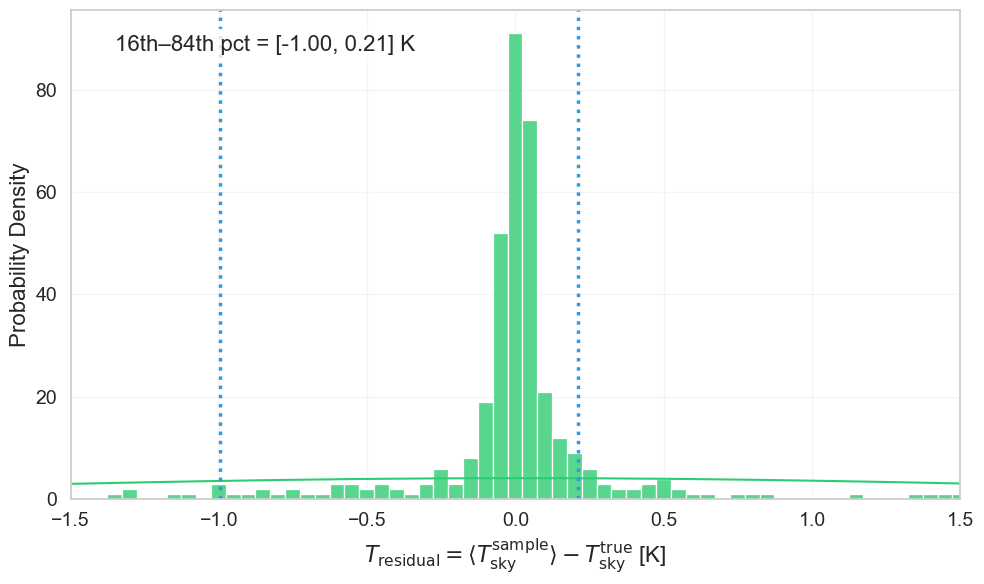

In [21]:
# Calculate residuals
residuals = Tmean - sky_params
from visualisation import *
plot_residual_histogram(residuals, save_path="./GS1_db_residuals_histogram.pdf")

In [ ]:
gain_prior_mean

In [22]:
# Get pixel coordinates
theta, phi = hp.pix2ang(nside, pixel_indices)
lon, lat = np.degrees(phi), 90 - np.degrees(theta)
lon_center, lat_center = np.median(lon), np.median(lat)

# Calculate appropriate zoom/resolution
patch_size = 100  # Add 20% margin
res = patch_size / 20  # Adjust resolution based on patch size

In [29]:
sky_min = 20
sky_max = 70

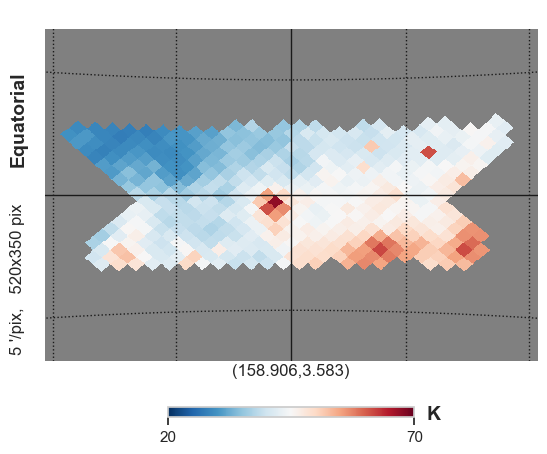

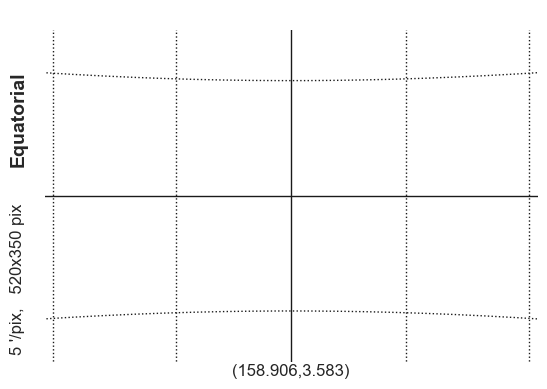

In [30]:
patch_true_map = view_patch_map(true_map, pixel_indices)

hp.gnomview(patch_true_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, 
           title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig('outputs/GS1_db/true_map.pdf', bbox_inches='tight', 
            pad_inches=0.1)

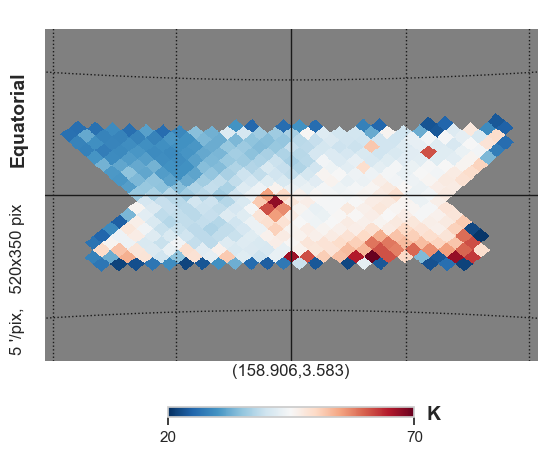

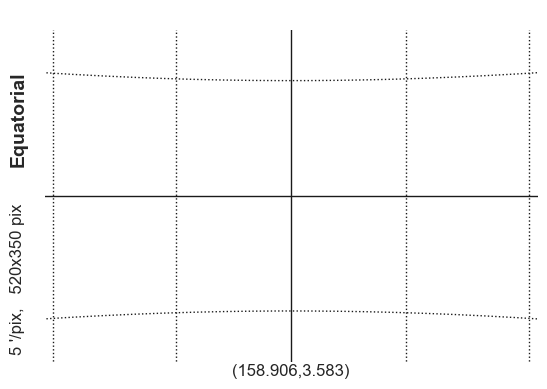

In [26]:
patch_mean_map = view_patch_map(sample_mean_map, pixel_indices)

hp.gnomview(patch_mean_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='jet', min=sky_min, max=sky_max,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False, badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS1_db/mean_map.pdf", bbox_inches='tight', 
            pad_inches=0.1)

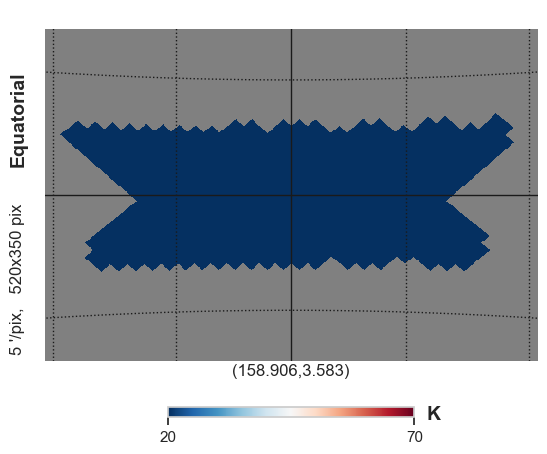

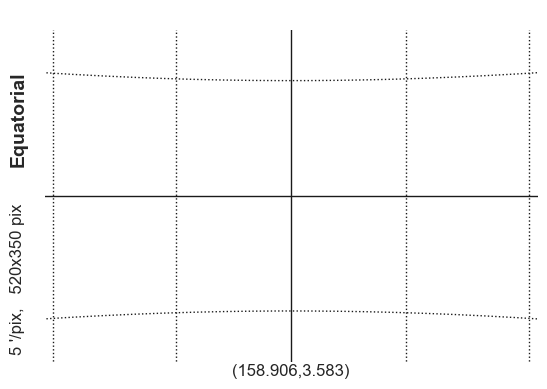

In [27]:
patch_error_map = view_patch_map(sample_mean_map-true_map, pixel_indices)
# plt.figure(figsize=(10, 6))
hp.gnomview(patch_error_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=" ", 
           unit="K", cmap='RdBu_r', min=-0.3, max=0.3,
           #notext=True,
           coord=['C'], 
           cbar=True, notext=False,
           badcolor='gray')
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS1_db/error_map_multi_TOD.pdf", bbox_inches='tight', 
            pad_inches=0.1)

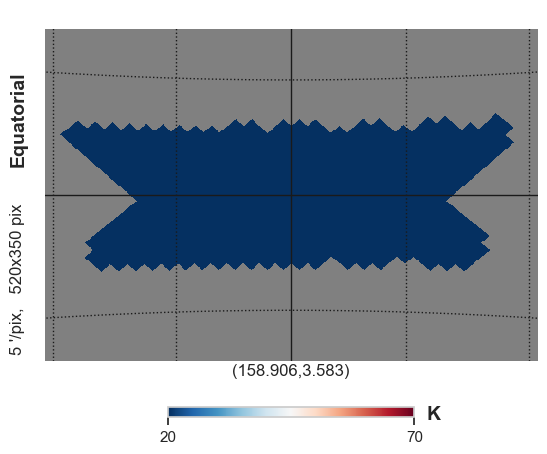

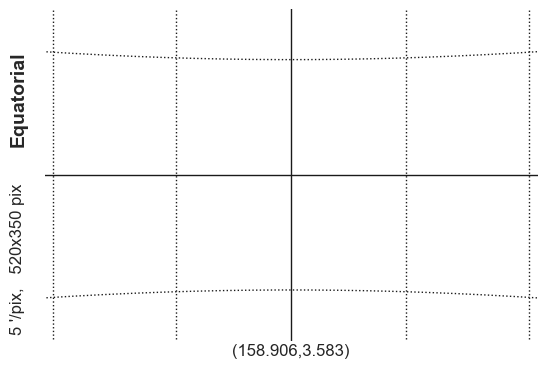

In [28]:
patch_std_map = view_patch_map(sample_std_map, pixel_indices)



hp.gnomview(patch_std_map, rot=(lon_center, lat_center), 
           xsize=520, ysize=350, reso=res, title=None, 
           unit="K", cmap='jet', 
           notext=False,
           coord=['C'], 
           cbar=True, 
           badcolor='gray',
           #sub=(2, 1, 1),  # Proper subplot specification
           #margins=(0.05, 0.15, 0.05, 0.15)
           )
#plt.grid(True)
hp.graticule(dpar=10, dmer=10, coord=['C'], local=True)  
#plt.grid(color='gray', linestyle=':', alpha=0.5)  # Custom grid style
plt.gca().set_facecolor('gray')  # Set background to white
plt.savefig("outputs/GS1_db/std_map_multi_TOD.pdf", bbox_inches='tight', 
            pad_inches=0.1)

In [ ]:

# # ---- Plot results ----
# # Generate a 2D plot of (RA, Dec) coordinates
# plt.figure(figsize=(12, 6))
# plt.scatter(equatorial_coords_setting.ra, equatorial_coords_setting.dec)
# plt.scatter(equatorial_coords_rising.ra, equatorial_coords_rising.dec)
# plt.xlabel("Right Ascension (degrees)")
# plt.ylabel("Declination (degrees)")
# plt.title("Sky Coordinates at Different Times")
# plt.show()


### Other components

In [ ]:
gain_samples.shape

In [ ]:
view_samples()

gain_samples = np.load("outputs/GS1_db/gain_samples.npy")